In [1]:
# Import the necessary packages

import pandas as pd
import numpy as np
import os
import PIL
import seaborn as sns
import pickle
from PIL import *
import cv2
import plotly.express as px
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.python.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# read the csv files for the facial expression data
facialexpression_df = pd.read_csv('icml_face_data.csv')

In [3]:
facialexpression_df.head()

emotion                                             pixels
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        0  151 150 147 155 148 133 111 140 170 174 182 15...
2        2  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
3        2  20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...
4        3  77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...

In [4]:
facialexpression_df.info()
# pixels are in string format

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24568 entries, 0 to 24567
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  24568 non-null  int64 
 1   pixels   24568 non-null  object
dtypes: int64(1), object(1)
memory usage: 384.0+ KB


In [5]:
# function to convert pixel values in string format to array format

def string2array(x):
  return np.array(x.split()).reshape(48, 48, 1).astype('float32')

In [6]:
# Resize images from (48, 48) to (96, 96) because in features detection dataset, image size was (96, 96)

def resize(x):
  
  img = x.reshape(48, 48)
  return cv2.resize(img, dsize=(96, 96), interpolation = cv2.INTER_CUBIC)

In [7]:
facialexpression_df['pixels'] = facialexpression_df['pixels'].apply(lambda x: string2array(x))

In [8]:
facialexpression_df['pixels'] = facialexpression_df['pixels'].apply(lambda x: resize(x))

In [9]:
facialexpression_df

emotion                                             pixels
0            0  [[69.316925, 73.03865, 79.13719, 84.17186, 85....
1            0  [[151.09435, 150.91393, 150.65791, 148.96367, ...
2            2  [[23.061905, 25.50914, 29.47847, 33.99843, 36....
3            2  [[20.083221, 19.079437, 17.398712, 17.158691, ...
4            3  [[76.26172, 76.54747, 77.001785, 77.7672, 78.4...
...        ...                                                ...
24563        3  [[-4.901001, 5.6496277, 22.477203, 49.366516, ...
24564        0  [[181.71645, 179.72063, 176.40785, 175.93037, ...
24565        3  [[178.1166, 176.83118, 174.74146, 172.61276, 1...
24566        0  [[16.883408, 16.953583, 17.081573, 16.53476, 1...
24567        3  [[30.199814, 29.574478, 28.545822, 27.846603, ...

[24568 rows x 2 columns]

In [10]:
# check the shape of data_frame
facialexpression_df.shape

(24568, 2)

In [11]:
# check for the presence of null values in the data frame
facialexpression_df.isnull().sum()

emotion    0
pixels     0
dtype: int64

In [12]:
label_to_text = {0:'anger', 1:'disgust', 2:'sad', 3:'happiness', 4: 'surprise'}

# VISUALIZE IMAGES AND PLOT LABELS

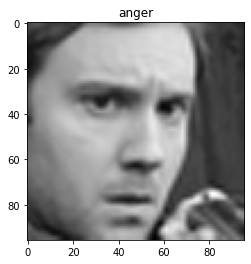

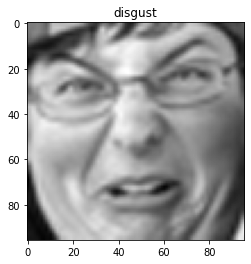

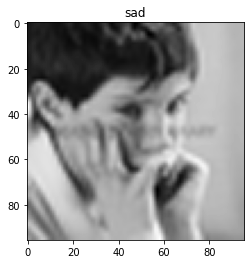

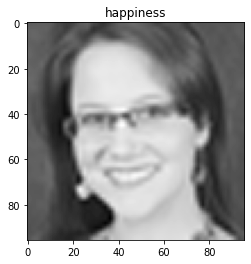

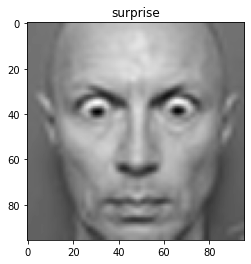

In [13]:
emotions = [0, 1, 2, 3, 4]

for i in emotions:
  data = facialexpression_df[facialexpression_df['emotion'] == i][:1]
  img = data['pixels'].item()
  img = img.reshape(96, 96)
  plt.figure()
  plt.title(label_to_text[i])
  plt.imshow(img, cmap = 'gray')

In [14]:
fig = px.bar(facialexpression_df['emotion'].value_counts(), title='Images Present Per Emotion')
fig.show()

# DATA PREPERATION

In [15]:
# split the dataframe in to features and labels
from keras.utils import to_categorical

X = facialexpression_df['pixels']
y = to_categorical(facialexpression_df['emotion'])

In [16]:
y

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [17]:
X = np.stack(X, axis = 0)
X = X.reshape(24568, 96, 96, 1)

print(X.shape, y.shape)

(24568, 96, 96, 1) (24568, 5)


In [18]:
# split the dataframe in to train, test and validation data frames

from sklearn.model_selection import train_test_split

X_train, X_Test, y_train, y_Test = train_test_split(X, y, test_size = 0.1, shuffle = True)
X_val, X_Test, y_val, y_Test = train_test_split(X_Test, y_Test, test_size = 0.5, shuffle = True)

In [19]:
print(X_val.shape, y_val.shape)

(1228, 96, 96, 1) (1228, 5)


In [20]:
print(X_Test.shape, y_Test.shape)

(1229, 96, 96, 1) (1229, 5)


In [21]:
print(X_train.shape, y_train.shape)

(22111, 96, 96, 1) (22111, 5)


In [22]:
# image pre-processing (Normalisation)

X_train = X_train/255
X_val   = X_val /255
X_Test  = X_Test/255

In [23]:
# Image Augmentation
train_datagen = ImageDataGenerator(
    rotation_range = 15,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    fill_mode = "nearest")

In [24]:
train_datagen = ImageDataGenerator(
    rotation_range = 15,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    vertical_flip = True,
    fill_mode = "nearest")

# BUILDING AND TRAINING DEEP LEARNING MODEL FOR FACIAL EXPRESSION CLASSIFICATION

In [25]:
def res_block(X, filter, stage):

  # Convolutional_block
  X_copy = X

  f1 , f2, f3 = filter

  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = MaxPool2D((2,2))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)


  # Short path
  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 1
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 2
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [26]:
input_shape = (96, 96, 1)

# Input tensor shape
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3, 3))(X_input)

# 1 - stage
X = Conv2D(64, (7, 7), strides= (2, 2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3, 3), strides= (2, 2))(X)

# 2 - stage
X = res_block(X, filter= [64, 64, 256], stage= 2)

# 3 - stage
X = res_block(X, filter= [128, 128, 512], stage= 3)

# Average Pooling
X = AveragePooling2D((4, 4), name = 'Averagea_Pooling')(X)

# Final layer
X = Flatten()(X)
X = Dense(5, activation = 'softmax', name = 'Dense_final', kernel_initializer= glorot_uniform(seed=0))(X)

model_emotion = Model( inputs= X_input, outputs = X, name = 'Resnet18')

model_emotion.summary()

Model: "Resnet18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 102, 102, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   3200        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 48, 48, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [27]:
# train the network
model_emotion.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [28]:
# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath = "FacialExpression_weights.hdf5", verbose = 1, save_best_only=True)

In [29]:
history = model_emotion.fit(train_datagen.flow(X_train, y_train, batch_size=64),
                              validation_data=(X_val, y_val), steps_per_epoch=len(X_train) // 64,
                              epochs= 200, callbacks=[checkpointer, earlystopping])

Epoch 1/200
345/345 [==============================] - ETA: 0s - loss: 1.3696 - accuracy: 0.4315
Epoch 00001: val_loss improved from inf to 1.59797, saving model to FacialExpression_weights.hdf5
345/345 [==============================] - 40s 115ms/step - loss: 1.3696 - accuracy: 0.4315 - val_loss: 1.5980 - val_accuracy: 0.3754
Epoch 2/200
345/345 [==============================] - ETA: 0s - loss: 1.0509 - accuracy: 0.5777
Epoch 00002: val_loss improved from 1.59797 to 1.06774, saving model to FacialExpression_weights.hdf5
345/345 [==============================] - 38s 110ms/step - loss: 1.0509 - accuracy: 0.5777 - val_loss: 1.0677 - val_accuracy: 0.5733
Epoch 3/200
345/345 [==============================] - ETA: 0s - loss: 0.9254 - accuracy: 0.6349
Epoch 00003: val_loss did not improve from 1.06774
345/345 [==============================] - 36s 104ms/step - loss: 0.9254 - accuracy: 0.6349 - val_loss: 1.1882 - val_accuracy: 0.5733
Epoch 4/200
345/345 [==============================] - E

In [30]:
# saving the model architecture to json file for future use

model_json = model_emotion.to_json()
with open("FacialExpression-model.json","w") as json_file:
  json_file.write(model_json)

# ACCESS THE PERFORMANCE OF THE MODEL

In [31]:
with open('FacialExpression-model.json', 'r') as json_file:
    json_savedModel= json_file.read()
#load the model architecture 
model_e = tf.keras.models.model_from_json(json_savedModel)
model_e.load_weights('FacialExpression_weights.hdf5')
model_e.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [32]:
score = model_e.evaluate(X_Test, y_Test)
print('Test Accuracy: {}'.format(score[1]))

39/39 [==============================] - 0s 12ms/step - loss: 0.6289 - accuracy: 0.7526
Test Accuracy: 0.752644419670105


In [33]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [34]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

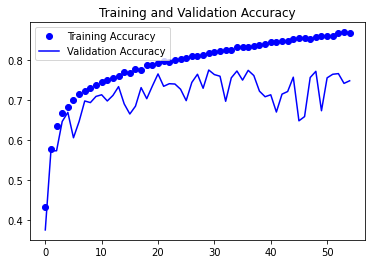

In [35]:
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

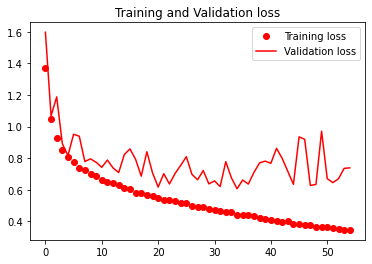

In [36]:
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

In [37]:
predicted_classes = np.argmax(model_e.predict(X_Test), axis=-1)
y_true = np.argmax(y_Test, axis=-1)

In [38]:
y_true.shape

(1229,)

<AxesSubplot:>

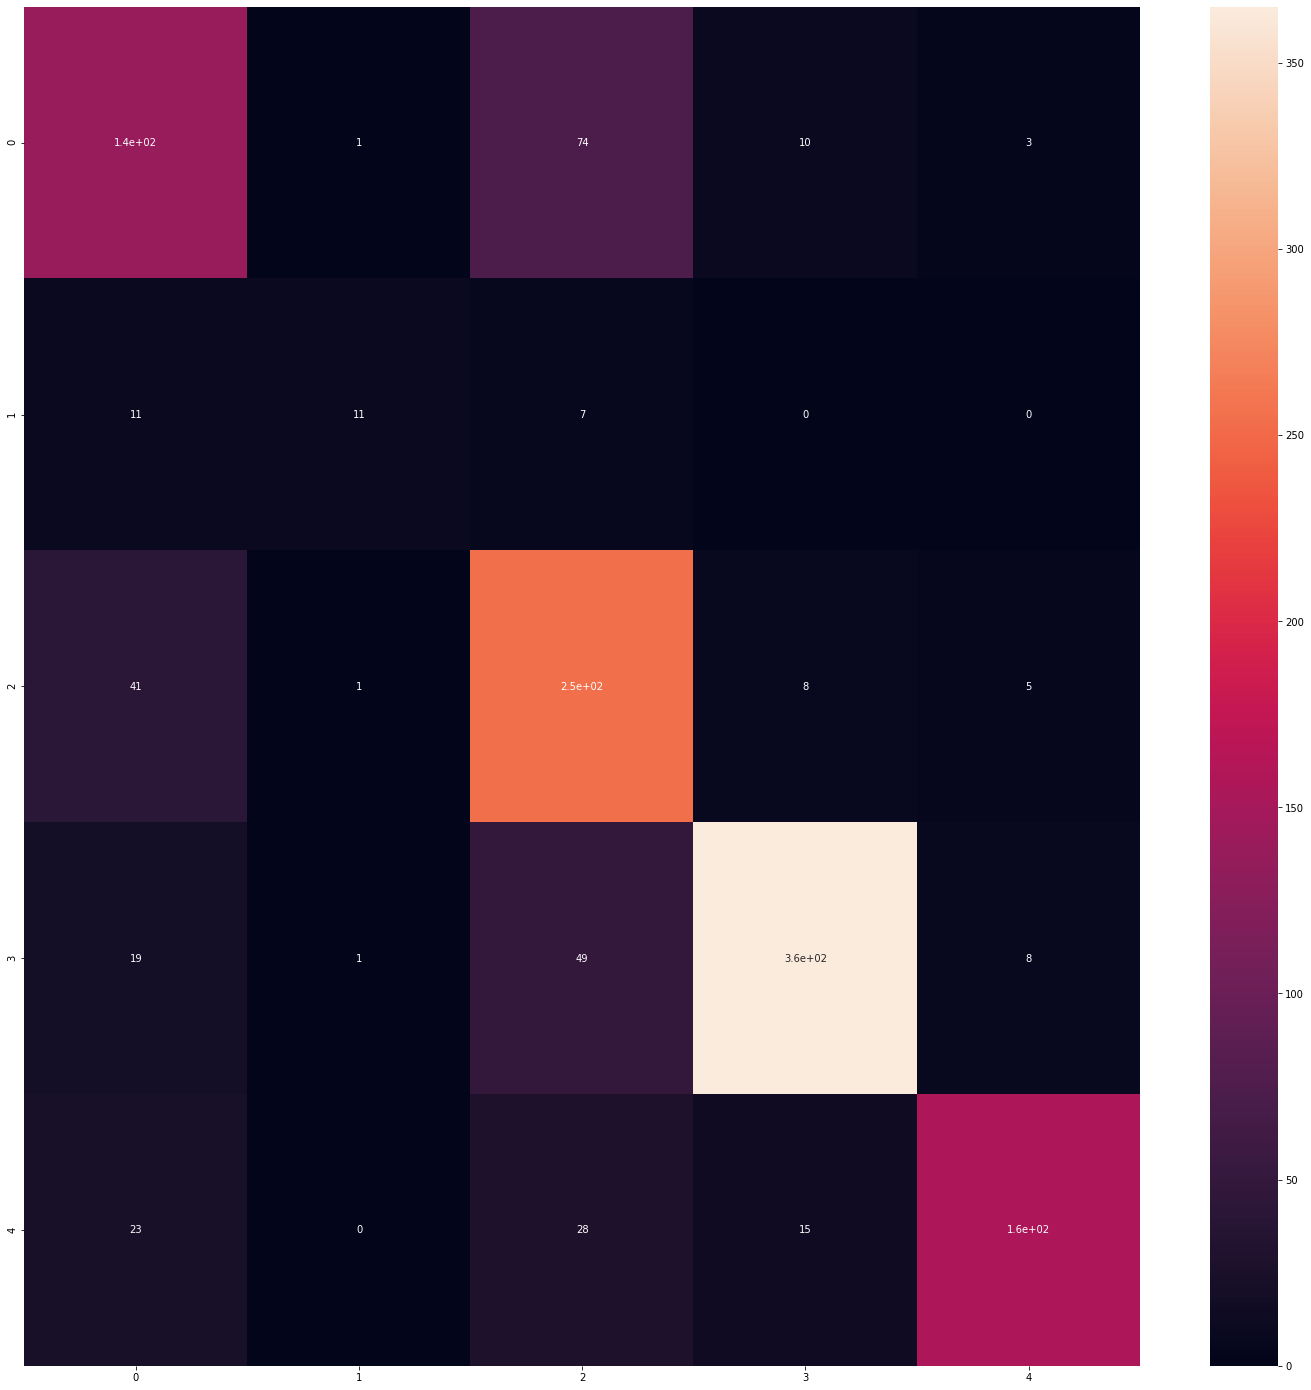

In [39]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, predicted_classes)
plt.figure(figsize = (25, 25))
sns.heatmap(cm, annot = True)

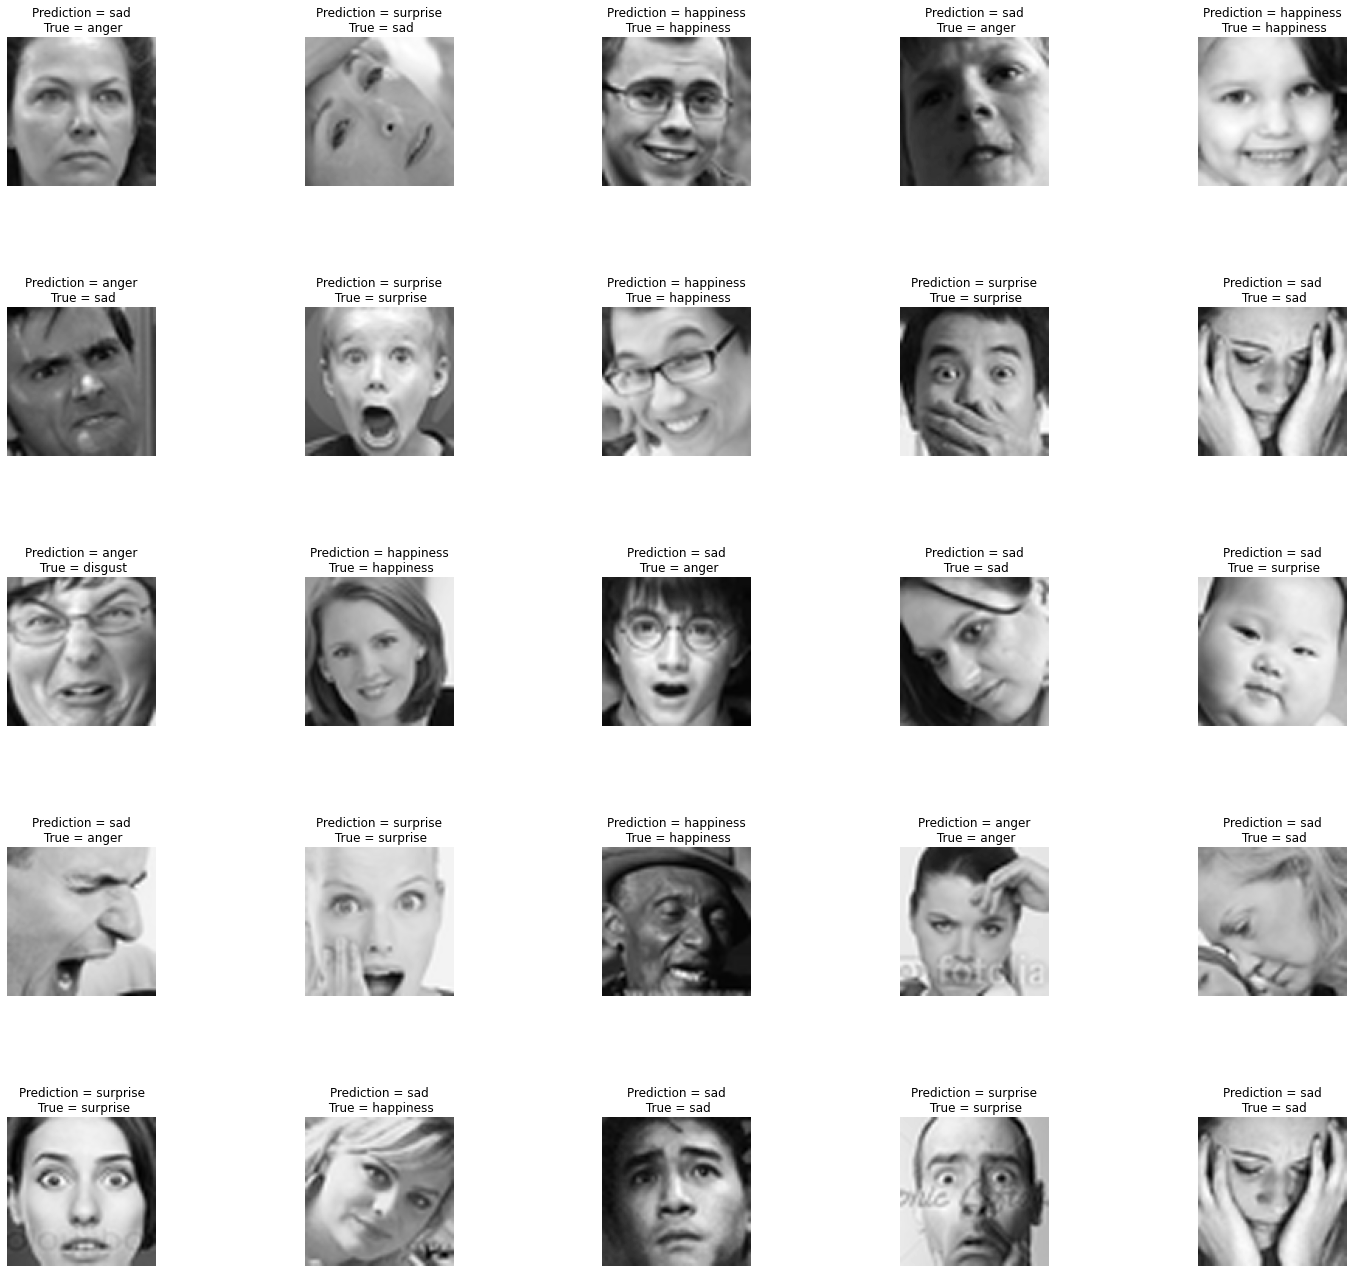

In [40]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (24, 24))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(X_Test[i].reshape(96,96), cmap = 'gray')
    axes[i].set_title('Prediction = {}\n True = {}'.format(label_to_text[predicted_classes[i]], label_to_text[y_true[i]]))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1)

In [42]:
from sklearn.metrics import classification_report
print(classification_report(y_true, predicted_classes))

              precision    recall  f1-score   support

           0       0.60      0.61      0.60       227
           1       0.79      0.38      0.51        29
           2       0.62      0.82      0.70       309
           3       0.92      0.83      0.87       442
           4       0.91      0.70      0.79       222

    accuracy                           0.75      1229
   macro avg       0.76      0.67      0.70      1229
weighted avg       0.78      0.75      0.76      1229

